In [1]:
import os
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm, pinv
%matplotlib inline
np.set_printoptions(precision=12, suppress=True)

In [2]:
zoomed_coords = True # whether to divide coordinates by SCALE_FAC or not (zoomed coords or not)
center_only = True # use only central stars
SCALE_FAC = 4.0 # Scale factor of coordinates

In [3]:
"""
Load star coords from txt-files
""";

In [4]:
coords_folder = 'data/star_coords/2016nov-11_txt/' # folder with coords files
images_folder = 'data/stars/2016nov-11/'
results_folder = 'results/2016nov-11/exp-Feb-2017'

In [5]:
# 2016nov-11 jpg
fnames = [
    "20161122-191517-359.txt",
    "20161122-201517-375.txt",
    "20161122-211517-375.txt",
    "20161122-221517-375.txt"
]

In [6]:
date = fnames[0][:-4]

In [7]:
im = Image.open(images_folder + "mod_" + date + "-1.jpg")
w, h = im.size
print "Image size:", w, h

Image size: 3072 2304


In [8]:
CENTER_RAD = 600 # radius(px) of central part
print 'CENTER_RAD:', CENTER_RAD

CENTER_RAD: 600


In [9]:
x_c, y_c = w/2, h/2 # central point of img
print 'x_c, y_c:', x_c, y_c

x_c, y_c: 1536 1152


"1." Берем область (круг) с центром в середине кадра, разных радиусов.
Считаем количество звезд. Определяем координаты выделенных звезд,
стараясь брать звезды малого размера, занимающих один пиксель.
Число звезд в кругах должно  отличаться на 3-4.

* R1 = 576px; 11 звезд учитыв-ся при подсчете коэфф
* R2 = 476px; 8 звезд учитыв-ся при подсчете коэфф

In [10]:
"""
Choose central stars (in central circle)
""";

In [11]:
coords_list = []
for fname in fnames:
    piece = np.loadtxt(coords_folder + os.sep + fname)
    coords_list.append(piece)

coords = np.vstack(coords_list)
print 'Zoomed In Star coordinates pairs (first 5):\n', coords[:5], '\n'

if zoomed_coords:
    coords /= float(SCALE_FAC)
    coords = coords.round()
    print 'Normal Star coordinates pairs (first 5):\n', coords[:5], '\n'


if center_only:
    coords_center = []
    
    for i in xrange(coords.shape[0]):
        _lx = coords[i, 0]
        _ly = coords[i, 1]
        _rx = coords[i, 2]
        _ry = coords[i, 3]
        if \
        (_lx - x_c)**2 + (_ly - y_c)**2 <= CENTER_RAD**2 and \
        (_rx - x_c)**2 + (_ry - y_c)**2 <= CENTER_RAD**2:
            coords_center.append(coords[i])
    
    coords = np.vstack(coords_center)
    print 'Normal Star coordinates pairs in center:\n', coords, '\n'
    print 'Num of star pairs chosen:', len(coords)

Zoomed In Star coordinates pairs (first 5):
[[  5734.   6266.   6711.   6411.]
 [  6490.   6723.   7468.   6866.]
 [  5934.   7360.   6910.   7507.]
 [  6209.   7975.   7190.   8129.]
 [  9774.   8478.  10880.   8711.]] 

Normal Star coordinates pairs (first 5):
[[ 1434.  1566.  1678.  1603.]
 [ 1622.  1681.  1867.  1716.]
 [ 1484.  1840.  1728.  1877.]
 [ 1552.  1994.  1798.  2032.]
 [ 2444.  2120.  2720.  2178.]] 

Normal Star coordinates pairs in center:
[[ 1434.  1566.  1678.  1603.]
 [ 1231.  1291.  1474.  1328.]
 [ 1438.  1360.  1680.  1397.]
 [ 1338.  1543.  1582.  1579.]
 [ 1436.  1673.  1680.  1709.]
 [  972.  1066.  1216.  1107.]
 [ 1192.  1089.  1433.  1128.]
 [ 1132.  1289.  1376.  1327.]
 [ 1256.  1393.  1499.  1430.]
 [ 1637.  1413.  1880.  1448.]
 [ 1753.   753.  1989.   784.]
 [ 1019.  1160.  1264.  1200.]] 

Num of star pairs chosen: 12


In [12]:
lX = coords[:, 0] # leftX coordinates
lY = coords[:, 1] # leftY coordinates
rX = coords[:, 2] # rightX coordinates
rY = coords[:, 3] # rightY coordinates

N = coords.shape[0] # number of pairs of points
M = coords.shape[1] # lX, lY, rX, rY == 4
print 'Number of Star coordinates pairs:', N

Number of Star coordinates pairs: 12


In [13]:
# Plot chosen star pairs
scatter_original = Image.new('RGB', (w, h), 'lightgray')
s_pix = scatter_original.load()

ELL_RAD = 3

scx_c = scatter_original.width / 2
scy_c = scatter_original.height / 2
draw = ImageDraw.Draw(scatter_original)
draw.ellipse((scx_c-ELL_RAD, scy_c-ELL_RAD, scx_c+ELL_RAD, scy_c+ELL_RAD), fill='darkgreen')

In [14]:
for i in xrange(N): # draw star points
    draw.ellipse((lX[i]-ELL_RAD, lY[i]-ELL_RAD, lX[i]+ELL_RAD, lY[i]+ELL_RAD), fill='red')
    draw.ellipse((rX[i]-ELL_RAD, rY[i]-ELL_RAD, rX[i]+ELL_RAD, rY[i]+ELL_RAD), fill='blue')

# Draw central part boundary
draw.ellipse((scx_c-CENTER_RAD, scy_c-CENTER_RAD, scx_c+CENTER_RAD, scy_c+CENTER_RAD), outline='black')

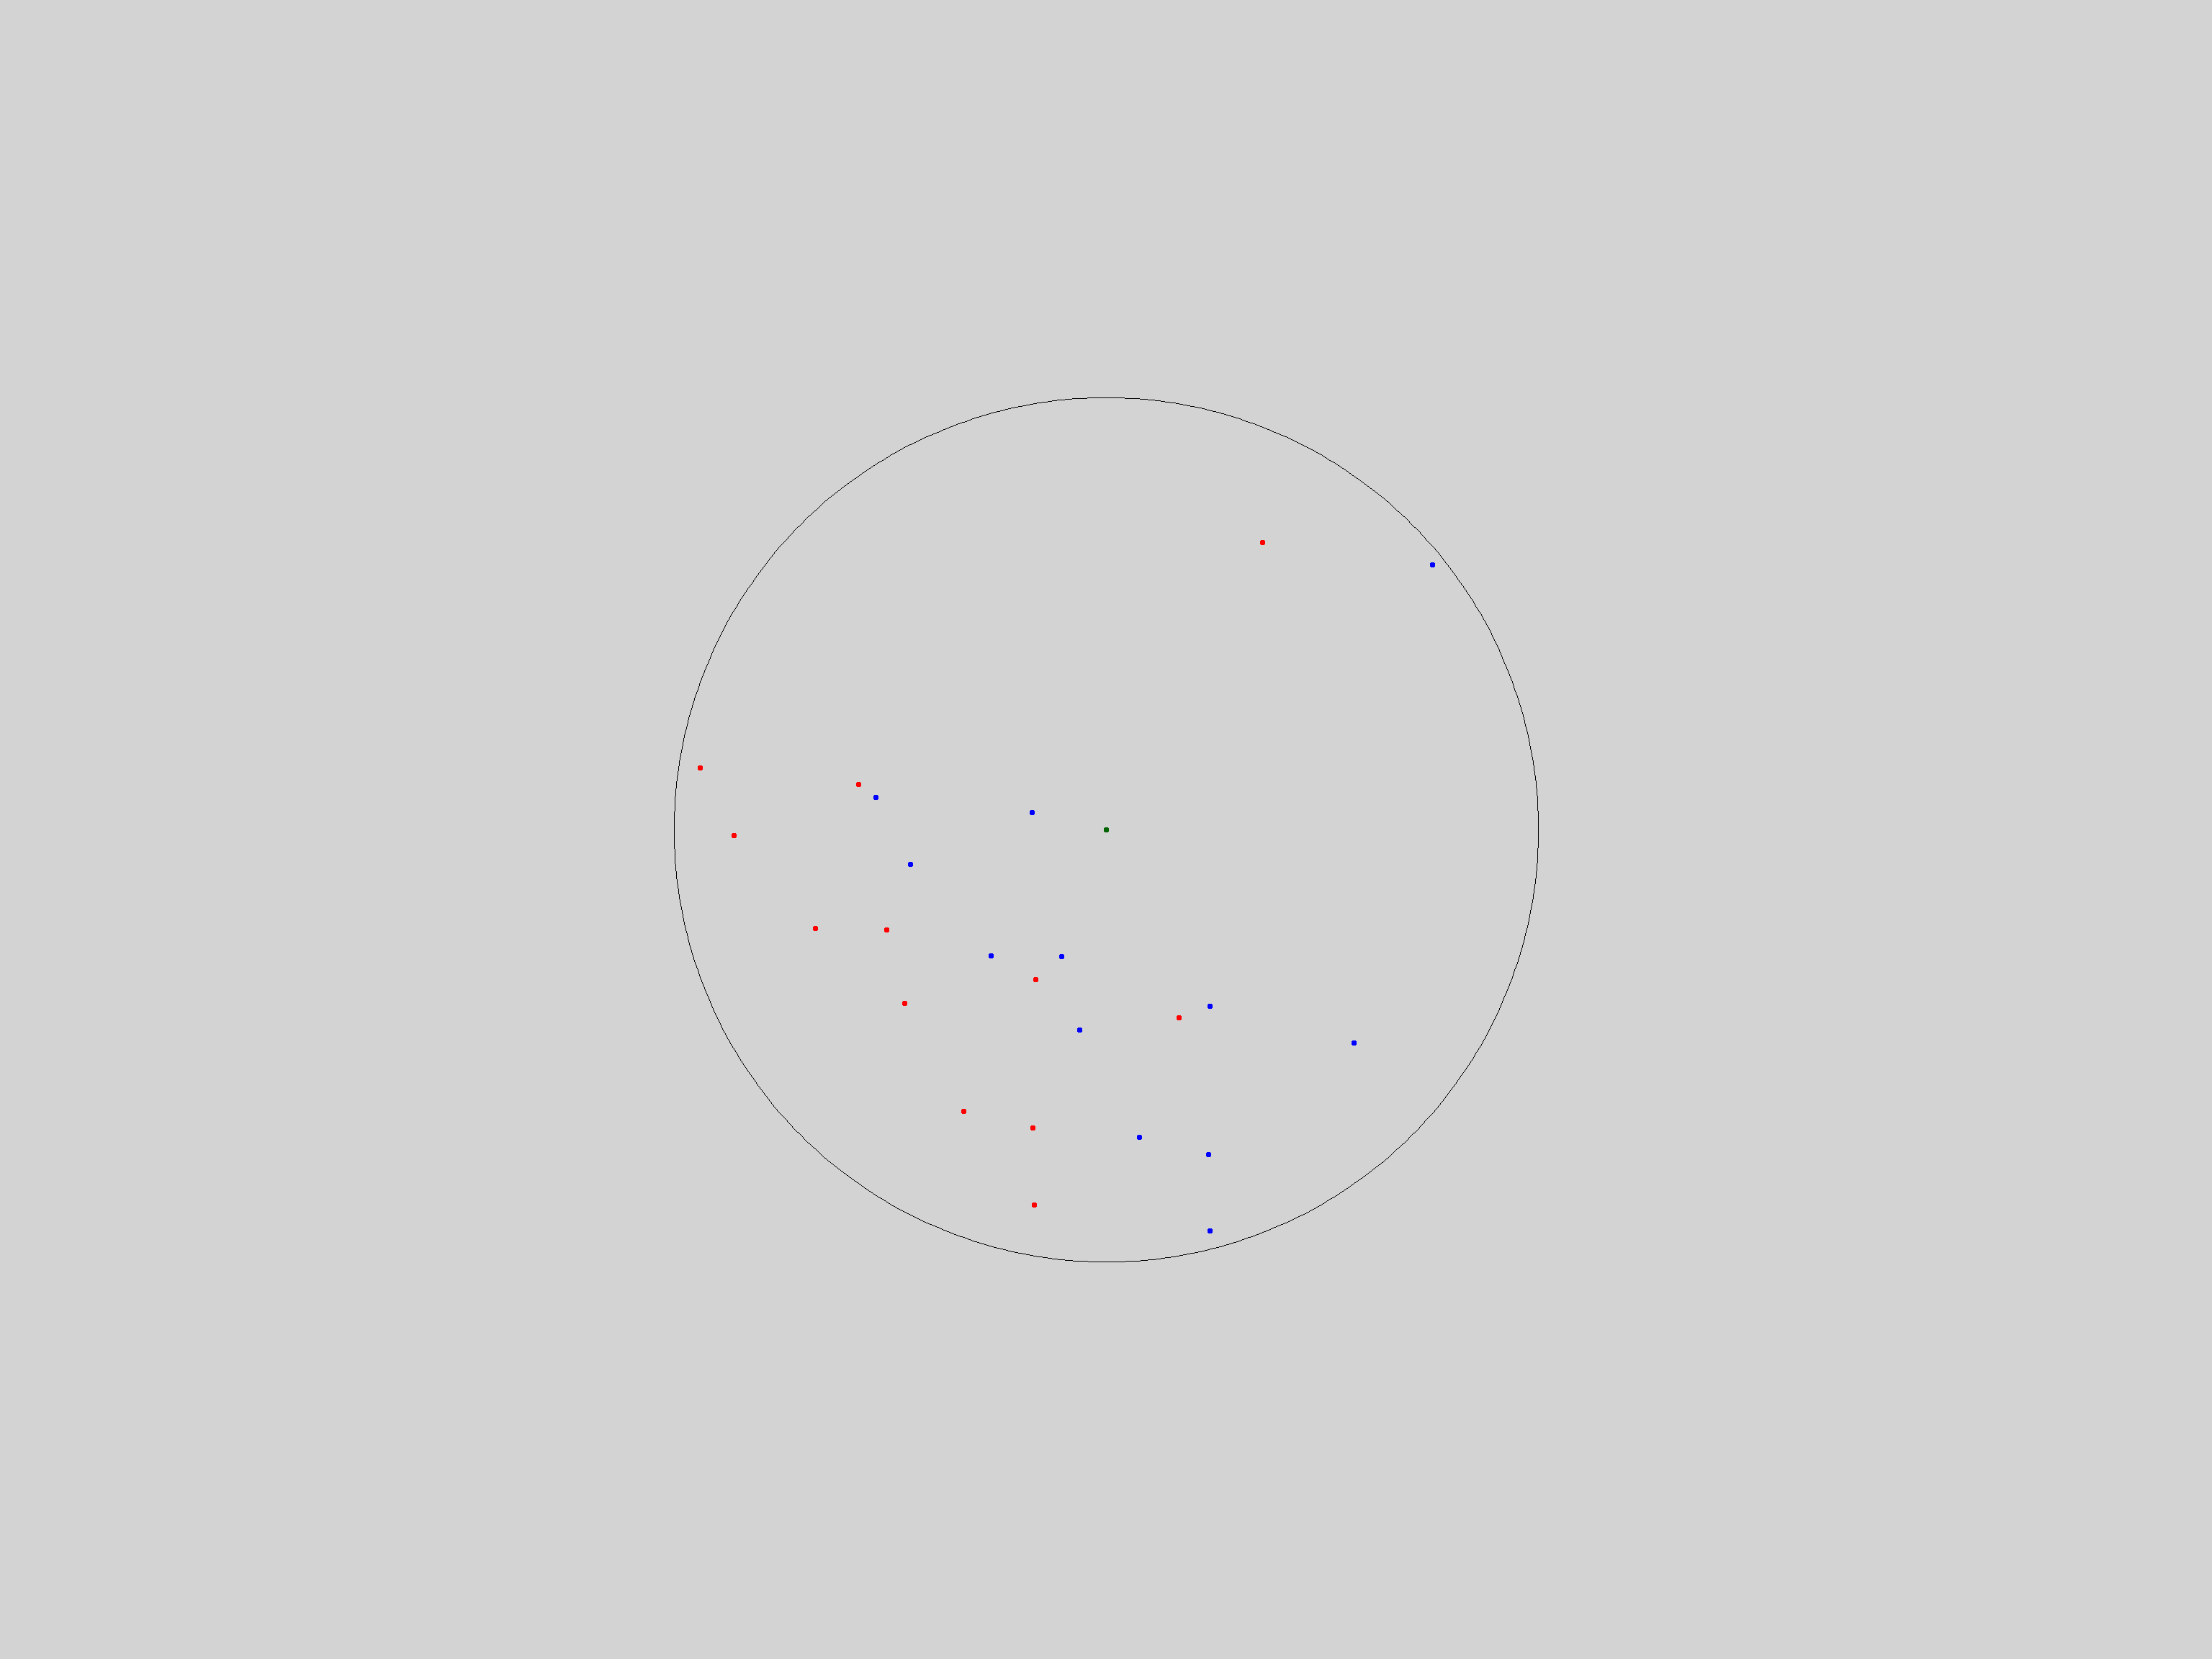

In [15]:
# Original stars' position
scatter_original

"2." Для каждого из набора звезд в выделенных кругах вычисляем
коэффициенты аффинного преобразования, коэффициенты
преобразования аффинного+дисторсии 3 порядка и коэффициенты
преобразования аффинного+дисторсии 3 порядка+дисторсии 5
порядка. Формулу для дисторсии 5 порядка можно посмотреть,
например, на сайте
https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D1%81%D1%82%D0%BE%D1%80%D1%81%D0%B8%D1%8F

Для дисторсии высших порядков  ($F_{n} при \; n>3$) в формулу добавляют по одному слагаемому на каждую дисторсию нечётного порядка ($F_{3}, F_{5}, F_{7} \;$ и т.п.):

$
\vec{R} = b_{0}\vec {r} + F_{3} r^{2} \vec{r} + F_{5} r^{4} \vec{r} + F_{7} r^{6} \vec{r} + \dots
$

и написать по аналогии с третьим порядком. Число звезд должно быть
больше, чем половина числа неизвестных параметров.

Вычисление проводится так.
Запишем схему измерения
$$
\xi = Af + \nu ,
$$

задаем матрицу А, матрицу $\Sigma$, являющуюся диагональной, и на ее
диагонали стоят дисперсии координат вектора погрешности $\nu$ . Здесь $f$ -- вектор неизвестных коэффициентов преобразований. Считаем эти дисперсии равными единице, т.е. $\Sigma = I$ -- единичная матрица

Оценка коэффициентов вычисляется по формуле
$$
    \hat{f} = A^- \xi
$$

In [16]:
xi = np.zeros(2*N)

for i in xrange(N): # fill the xi vector
    xi[2*i] = rX[i]
    xi[2*i + 1] = rY[i]

print 'xi:\n', xi

xi:
[ 1678.  1603.  1474.  1328.  1680.  1397.  1582.  1579.  1680.  1709.
  1216.  1107.  1433.  1128.  1376.  1327.  1499.  1430.  1880.  1448.
  1989.   784.  1264.  1200.]


In [17]:
"""
Calculate coeff-s

a) Affine (at least 3 stars)
""";

In [18]:
k = 6 # num of coeff-s

z = np.zeros(k)
arr = np.zeros((2*N, k)) # matrix A

In [19]:
for i in xrange(N): # fill the A matrix
    
    arr[2*i] = [lX[i], lY[i], 0, 0, 1, 0]

    arr[2*i + 1] = [0, 0, lX[i], lY[i], 0, 1]

In [20]:
np.set_printoptions(precision=2, suppress=True)
print 'A:\n', arr[:4], '\n'
np.set_printoptions(precision=12, suppress=True)

A:
[[ 1434.  1566.     0.     0.     1.     0.]
 [    0.     0.  1434.  1566.     0.     1.]
 [ 1231.  1291.     0.     0.     1.     0.]
 [    0.     0.  1231.  1291.     0.     1.]] 



In [21]:
p_arr = pinv(arr)
z = np.dot(p_arr, xi)
print """
Affine coefficients:
%.4f %.4f %.4f %.4f 
%.2f %.2f""" % tuple(z)
print 'cond(A): ', np.linalg.cond(arr)


Affine coefficients:
0.9934 0.0067 -0.0102 1.0014 
242.80 48.66
cond(A):  14609.6186715


In [22]:
"""
b) Affine + Ditortion 3rd order 
  (at least 4 stars)
""";

In [23]:
k3 = 8

z3 = np.zeros(k3)
arr3 = np.zeros((2*N, k3)) # matrix A

In [24]:
for i in xrange(N): # fill the A matrix
    dist_l = (lX[i]-x_c)**2 + (lY[i]-y_c)**2
    dist_r = (rX[i]-x_c)**2 + (rY[i]-y_c)**2

    zx1 = (lX[i] - x_c) * dist_l
    zx2 = (rX[i] - x_c) * dist_r
    arr3[2*i] = [lX[i], lY[i], 0, 0, 1, 0, -zx1, zx2]

    zy1 = (lY[i] - y_c) * dist_l
    zy2 = (rY[i] - y_c) * dist_r
    arr3[2*i + 1] = [0, 0, lX[i], lY[i], 0, 1, -zy1, zy2]


In [25]:
np.set_printoptions(precision=2)
print 'A:\n', arr3[:4], '\n'
np.set_printoptions(precision=4)

A:
[[  1.43e+03   1.57e+03   0.00e+00   0.00e+00   1.00e+00   0.00e+00
    1.85e+07   3.17e+07]
 [  0.00e+00   0.00e+00   1.43e+03   1.57e+03   0.00e+00   1.00e+00
   -7.53e+07   1.01e+08]
 [  1.23e+03   1.29e+03   0.00e+00   0.00e+00   1.00e+00   0.00e+00
    3.43e+07  -2.16e+06]
 [  0.00e+00   0.00e+00   1.23e+03   1.29e+03   0.00e+00   1.00e+00
   -1.56e+07   6.13e+06]] 



In [26]:
p_arr3 = pinv(arr3)
z3 = np.dot(p_arr3, xi)
print """
Affine coefficients + Ditortion 3rd order: 
%.4f %.4f %.4f %.4f 
%.2f %.2f 
%.2e %.2e""" % tuple(z3)
print 'cond(A): ', np.linalg.cond(arr3)


Affine coefficients + Ditortion 3rd order: 
0.9955 0.0081 -0.0101 1.0017 
236.81 48.21 
2.28e-08 1.66e-08
cond(A):  2284107313.17


In [27]:
"""
c) Affine + Ditortion 3rd, 5th orders 
  (at least 5 stars)
""";

In [28]:
k35 = 10

z35 = np.zeros(k35)
arr35 = np.zeros((2*N, k35)) # matrix A

In [29]:
for i in xrange(N): # fill the A matrix
    dist_l = (lX[i]-x_c)**2 + (lY[i]-y_c)**2
    dist_r = (rX[i]-x_c)**2 + (rY[i]-y_c)**2

    zx1 = (lX[i] - x_c) * dist_l
    zx2 = (rX[i] - x_c) * dist_r
    wx1 = (lX[i] - x_c) * dist_l**2
    wx2 = (rX[i] - x_c) * dist_r**2

    arr35[2*i] = [lX[i], lY[i], 0, 0, 1, 0, -zx1, zx2, -wx1, wx2]

    zy1 = (lY[i] - y_c) * dist_l
    zy2 = (rY[i] - y_c) * dist_r
    wy1 = (lY[i] - y_c) * dist_l**2
    wy2 = (rY[i] - y_c) * dist_r**2

    arr35[2*i + 1] = [0, 0, lX[i], lY[i], 0, 1, -zy1, zy2, -wy1, wy2]


In [30]:
np.set_printoptions(precision=2, suppress=True)
print 'A:\n', arr35[:4], '\n'

A:
[[  1.43e+03   1.57e+03   0.00e+00   0.00e+00   1.00e+00   0.00e+00
    1.85e+07   3.17e+07   3.37e+12   7.10e+12]
 [  0.00e+00   0.00e+00   1.43e+03   1.57e+03   0.00e+00   1.00e+00
   -7.53e+07   1.01e+08  -1.37e+13   2.25e+13]
 [  1.23e+03   1.29e+03   0.00e+00   0.00e+00   1.00e+00   0.00e+00
    3.43e+07  -2.16e+06   3.85e+12  -7.52e+10]
 [  0.00e+00   0.00e+00   1.23e+03   1.29e+03   0.00e+00   1.00e+00
   -1.56e+07   6.13e+06  -1.75e+12   2.13e+11]] 



In [31]:
p_arr35 = pinv(arr35, rcond=1e-18)
z35 = np.dot(p_arr35, xi)
np.set_printoptions(precision=4)
print """
Affine coefficients + Ditortion 3rd, 5th orders:

%.4f %.4f %.4f %.4f 
%.2f %.2f 
%.2e %.2e 
%.2e %.2e""" % tuple(z35)
print 'cond(A): ', np.linalg.cond(arr35)


Affine coefficients + Ditortion 3rd, 5th orders:

0.9986 0.0071 -0.0116 1.0050 
232.16 45.99 
1.06e-07 7.60e-08 
-2.00e-13 -1.42e-13
cond(A):  1.3806373694e+15


Погрешность оценки коэффициентов определяется матрицей
$$
    \Sigma_f = \left( A^* \Sigma A \right)^{-1} 
             = \left(A^* A \right)^{-1}
$$

In [32]:
"""
Calculate error matrix \Sigma_f
""";

[[  1.6591e-06  -7.3406e-08   0.0000e+00   0.0000e+00]
 [ -7.3406e-08   1.4073e-06   0.0000e+00   0.0000e+00]
 [  0.0000e+00   0.0000e+00   1.6591e-06  -7.3406e-08]
 [  0.0000e+00   0.0000e+00  -7.3406e-08   1.4073e-06]]


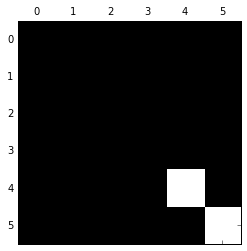

In [33]:
sig_mat = np.linalg.inv(arr.T.dot(arr))
plt.matshow(sig_mat, cmap=plt.cm.gray)
np.set_printoptions(suppress=False)
print sig_mat[:4, :4]

[[  9.5457e-06  -7.9122e-07  -4.6140e-07   8.6302e-06]
 [ -7.9122e-07   1.8914e-06   9.1031e-08  -1.3079e-06]
 [ -4.6140e-07   9.1031e-08   1.6918e-06  -6.3947e-07]
 [  8.6302e-06  -1.3079e-06  -6.3947e-07   1.1503e-05]]


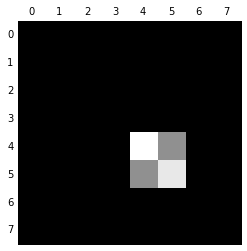

In [34]:
sig_mat3 = np.linalg.inv(arr3.T.dot(arr3))
plt.matshow(sig_mat3, cmap=plt.cm.gray)
np.set_printoptions(suppress=False)
print sig_mat3[:4, :4]

[[  4.2492e-05  -2.1998e-06  -2.1168e-06   4.4676e-05]
 [ -2.1998e-06   2.1475e-06   4.9595e-07  -2.8476e-06]
 [ -2.1168e-06   4.9595e-07   2.3451e-06  -2.4483e-06]
 [  4.4676e-05  -2.8476e-06  -2.4483e-06   5.0940e-05]]


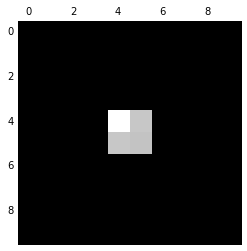

In [35]:
sig_mat35 = np.linalg.inv(arr35.T.dot(arr35))
plt.matshow(sig_mat35, cmap=plt.cm.gray)
np.set_printoptions(suppress=False)
print sig_mat35[:4, :4]

Надежность модели определяется значением случайной величины
$$
    \tau = \| \xi - AA^{-} \xi \|^2
$$

In [36]:
"""
Calculate reliability of model \tau,
(2N - k) / tau,
N -- number of central stars 
k -- number of coefficients(6, 8 or 10)
""";

In [37]:
N

12

In [38]:
tau = np.linalg.norm(xi - arr.dot(p_arr).dot(xi) ) ** 2
print "tau:", tau
print "(2N - k) / tau:", (2*N - k) / tau

tau: 15.8622164573
(2N - k) / tau: 1.13477205714


In [39]:
tau3 = np.linalg.norm(xi - arr3.dot(p_arr3).dot(xi) ) ** 2
print "tau3:", tau3
print "(2N - k3) / tau3:", (2*N - k3) / tau3

tau3: 9.27473221705
(2N - k3) / tau3: 1.72511719213


In [40]:
tau35 = np.linalg.norm(xi - arr35.dot(p_arr35).dot(xi) ) ** 2
print "tau35:", tau35
print "(2N - k35) / tau35:", (2*N - k35) / tau35

tau35: 5.76812132985
(2N - k35) / tau35: 2.42713341128


Выходные данные программы:

1) N – число звезд в круге

2) оценка коэффициентов $\; \hat{f} = A^- \xi$

3) матрица ошибок $\; \Sigma_f$

4) значение $\; \tau$ , а лучше – значение $\; \frac{2N - k}{\tau}$,
где k -- число коэффициентов (координат вектора f).

"3." Вычисляем преобразованное изображение одного из кадров и
накладываем его на изображение второго кадра. Для каждой звезды
вычисляем разность координат (по x и по y) двух (совмещенных) изображений звезд.

In [41]:
def affine_transform_point(x, y):
    return [b * y + x * a + e , d * y + x * c + f]

In [42]:
"""
Align images and blend

a) Affine
""";

In [43]:
a = float(z[0])
b = float(z[1])
c = float(z[2])
d = float(z[3])
e = float(z[4])
f = float(z[5])

In [44]:
nlX = np.zeros_like(lX)
nlY = np.zeros_like(lY)

In [45]:
# Calc new (affine transformed) points
for i in xrange(N): 
    nlX[i], nlY[i] = affine_transform_point(lX[i], lY[i])

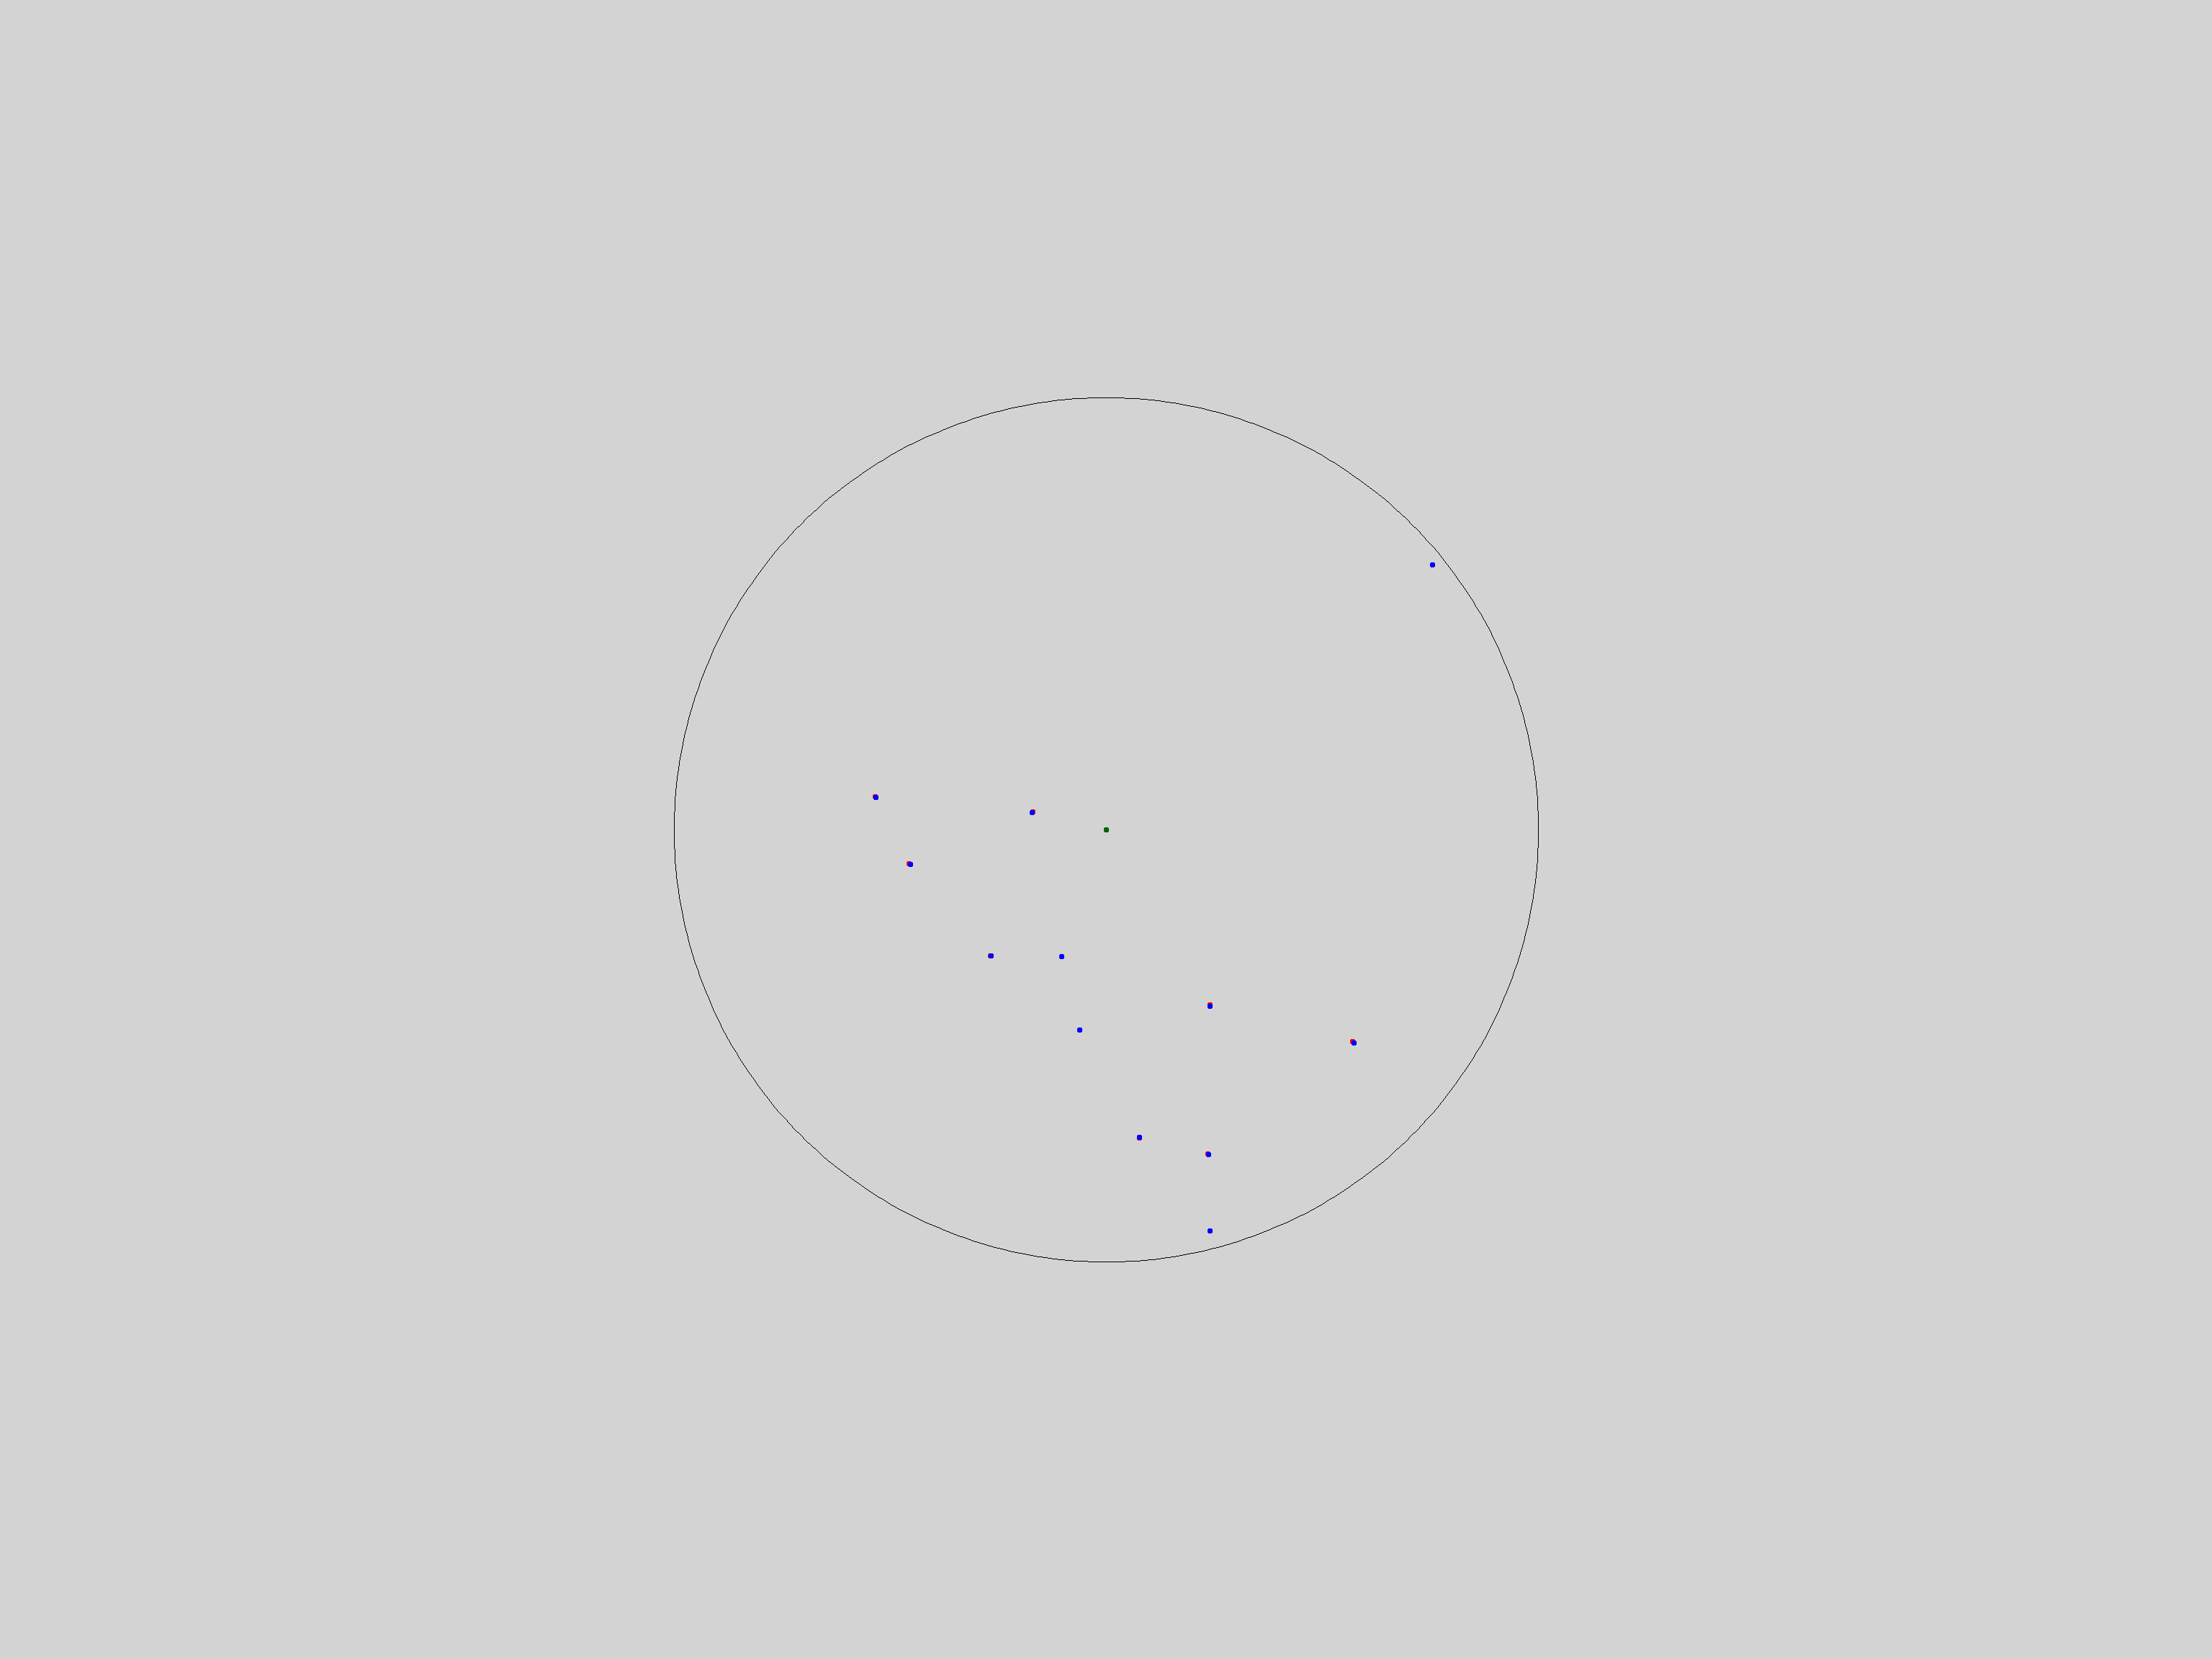

In [46]:
scatter = Image.new('RGB', (w, h), 'lightgray')


draw = ImageDraw.Draw(scatter)
draw.ellipse((x_c-ELL_RAD, y_c-ELL_RAD, x_c+ELL_RAD, y_c+ELL_RAD), fill='darkgreen')
# Draw central part boundary
draw.ellipse((x_c-CENTER_RAD, y_c-CENTER_RAD, x_c+CENTER_RAD, y_c+CENTER_RAD), outline='black')

for i in xrange(N): # draw star points
    draw.ellipse((nlX[i]-ELL_RAD, nlY[i]-ELL_RAD, nlX[i]+ELL_RAD, nlY[i]+ELL_RAD), fill='red')
    draw.ellipse((rX[i]-ELL_RAD, rY[i]-ELL_RAD, rX[i]+ELL_RAD, rY[i]+ELL_RAD), fill='blue')
scatter

In [47]:
"""
b) Affine + Ditortion3
""";

In [48]:
a = float(z3[0])
b = float(z3[1])
c = float(z3[2])
d = float(z3[3])
e = float(z3[4])
f = float(z3[5])

eps1 = float(z3[6])
eps2 = float(z3[7])

In [49]:
nlX3 = np.zeros_like(lX)
nlY3 = np.zeros_like(lY)
nrX3 = np.zeros_like(rX)
nrY3 = np.zeros_like(rY)

In [50]:
# Get rid of distortions on new left Img
for i in xrange(N): 
    dist_l = (lX[i] - x_c)**2 + (lY[i] - y_c)**2

    zx1 = (lX[i] - x_c) * dist_l
    zy1 = (lY[i] - y_c) * dist_l


    nlX3[i] = lX[i] - eps1 * zx1
    nlY3[i] = lY[i] - eps1 * zy1


# Get rid of distortions on new right Img

for i in xrange(N): 
    dist_r = (rX[i] - x_c)**2 + (rY[i] - y_c)**2

    zx2 = (rX[i] - x_c) * dist_r
    zy2 = (rY[i] - y_c) * dist_r


    nrX3[i] = rX[i] - eps2 * zx2
    nrY3[i] = rY[i] - eps2 * zy2


In [51]:
# Calc new (affine transformed) points
for i in xrange(N): 
    nlX3[i], nlY3[i] = affine_transform_point(lX[i], lY[i])

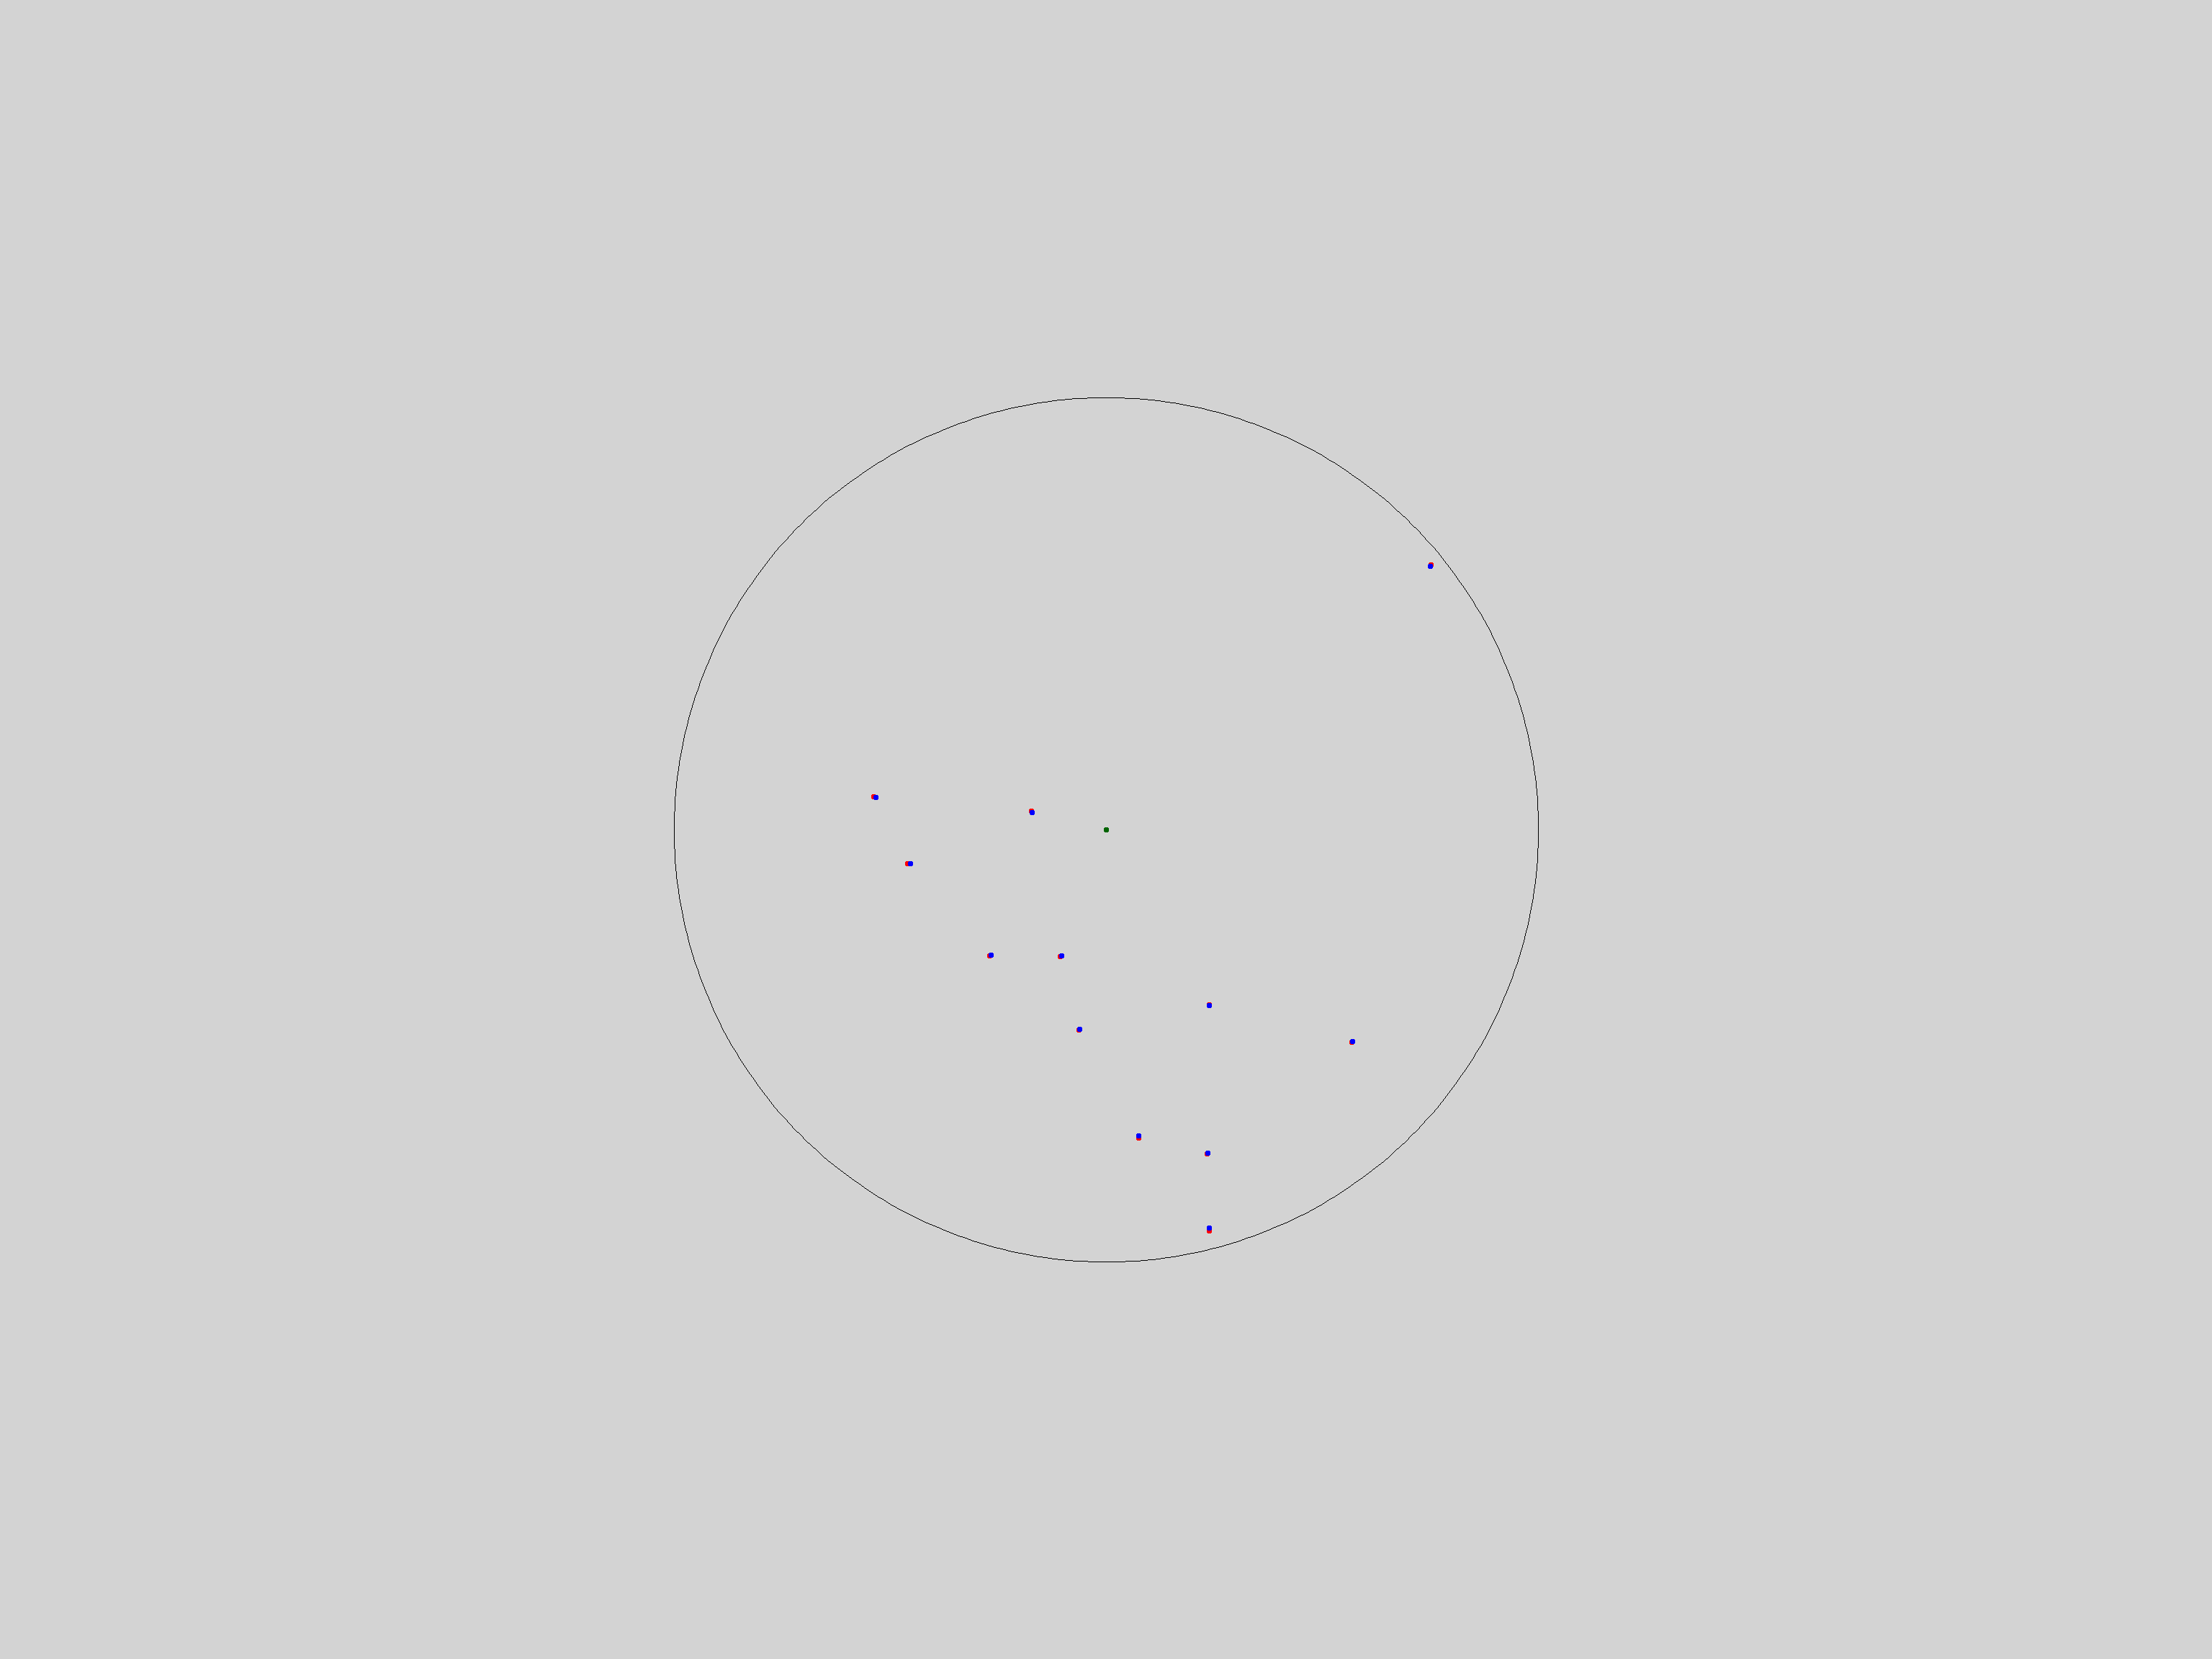

In [52]:
scatter3 = Image.new('RGB', (w, h), 'lightgray')


draw = ImageDraw.Draw(scatter3)
draw.ellipse((x_c-ELL_RAD, y_c-ELL_RAD, x_c+ELL_RAD, y_c+ELL_RAD), fill='darkgreen')
# Draw central part boundary
draw.ellipse((x_c-CENTER_RAD, y_c-CENTER_RAD, x_c+CENTER_RAD, y_c+CENTER_RAD), outline='black')

for i in xrange(N): # draw star points
    draw.ellipse((nlX3[i]-ELL_RAD, nlY3[i]-ELL_RAD, nlX3[i]+ELL_RAD, nlY3[i]+ELL_RAD), fill='red')
    draw.ellipse((nrX3[i]-ELL_RAD, nrY3[i]-ELL_RAD, nrX3[i]+ELL_RAD, nrY3[i]+ELL_RAD), fill='blue')
scatter3

In [53]:
"""
c) Affine + Ditortion3,5
""";

In [54]:
a = float(z35[0])
b = float(z35[1])
c = float(z35[2])
d = float(z35[3])
e = float(z35[4])
f = float(z35[5])

eps1 = float(z35[6])
eps2 = float(z35[7])
eps3 = float(z35[8])
eps4 = float(z35[9])

In [55]:
nlX35 = np.zeros_like(lX)
nlY35 = np.zeros_like(lY)
nrX35 = np.zeros_like(rX)
nrY35 = np.zeros_like(rY)

In [56]:
# Get rid of distortions on new left Img
for i in xrange(N): 
    dist_l = (lX[i] - x_c)**2 + (lY[i] - y_c)**2

    zx1 = (lX[i] - x_c) * dist_l
    zy1 = (lY[i] - y_c) * dist_l
    wx1 = (lX[i] - x_c) * dist_l**2
    wy1 = (lY[i] - y_c) * dist_l**2

    
    nlX35[i] = lX[i] - eps1 * zx1 - eps3 * wx1
    nlY35[i] = lY[i] - eps1 * zy1 - eps3 * wy1


# Get rid of distortions on new right Img

for i in xrange(N): 
    dist_r = (rX[i] - x_c)**2 + (rY[i] - y_c)**2

    zx2 = (rX[i] - x_c) * dist_r
    zy2 = (rY[i] - y_c) * dist_r
    wx2 = (rX[i] - x_c) * dist_r**2
    wy2 = (rY[i] - y_c) * dist_r**2


    nrX35[i] = rX[i] - eps2 * zx2 - eps4 * wx2
    nrY35[i] = rY[i] - eps2 * zy2 - eps4 * wy2


In [57]:
# Calc new (affine transformed) points
for i in xrange(N): 
    nlX35[i], nlY35[i] = affine_transform_point(lX[i], lY[i])

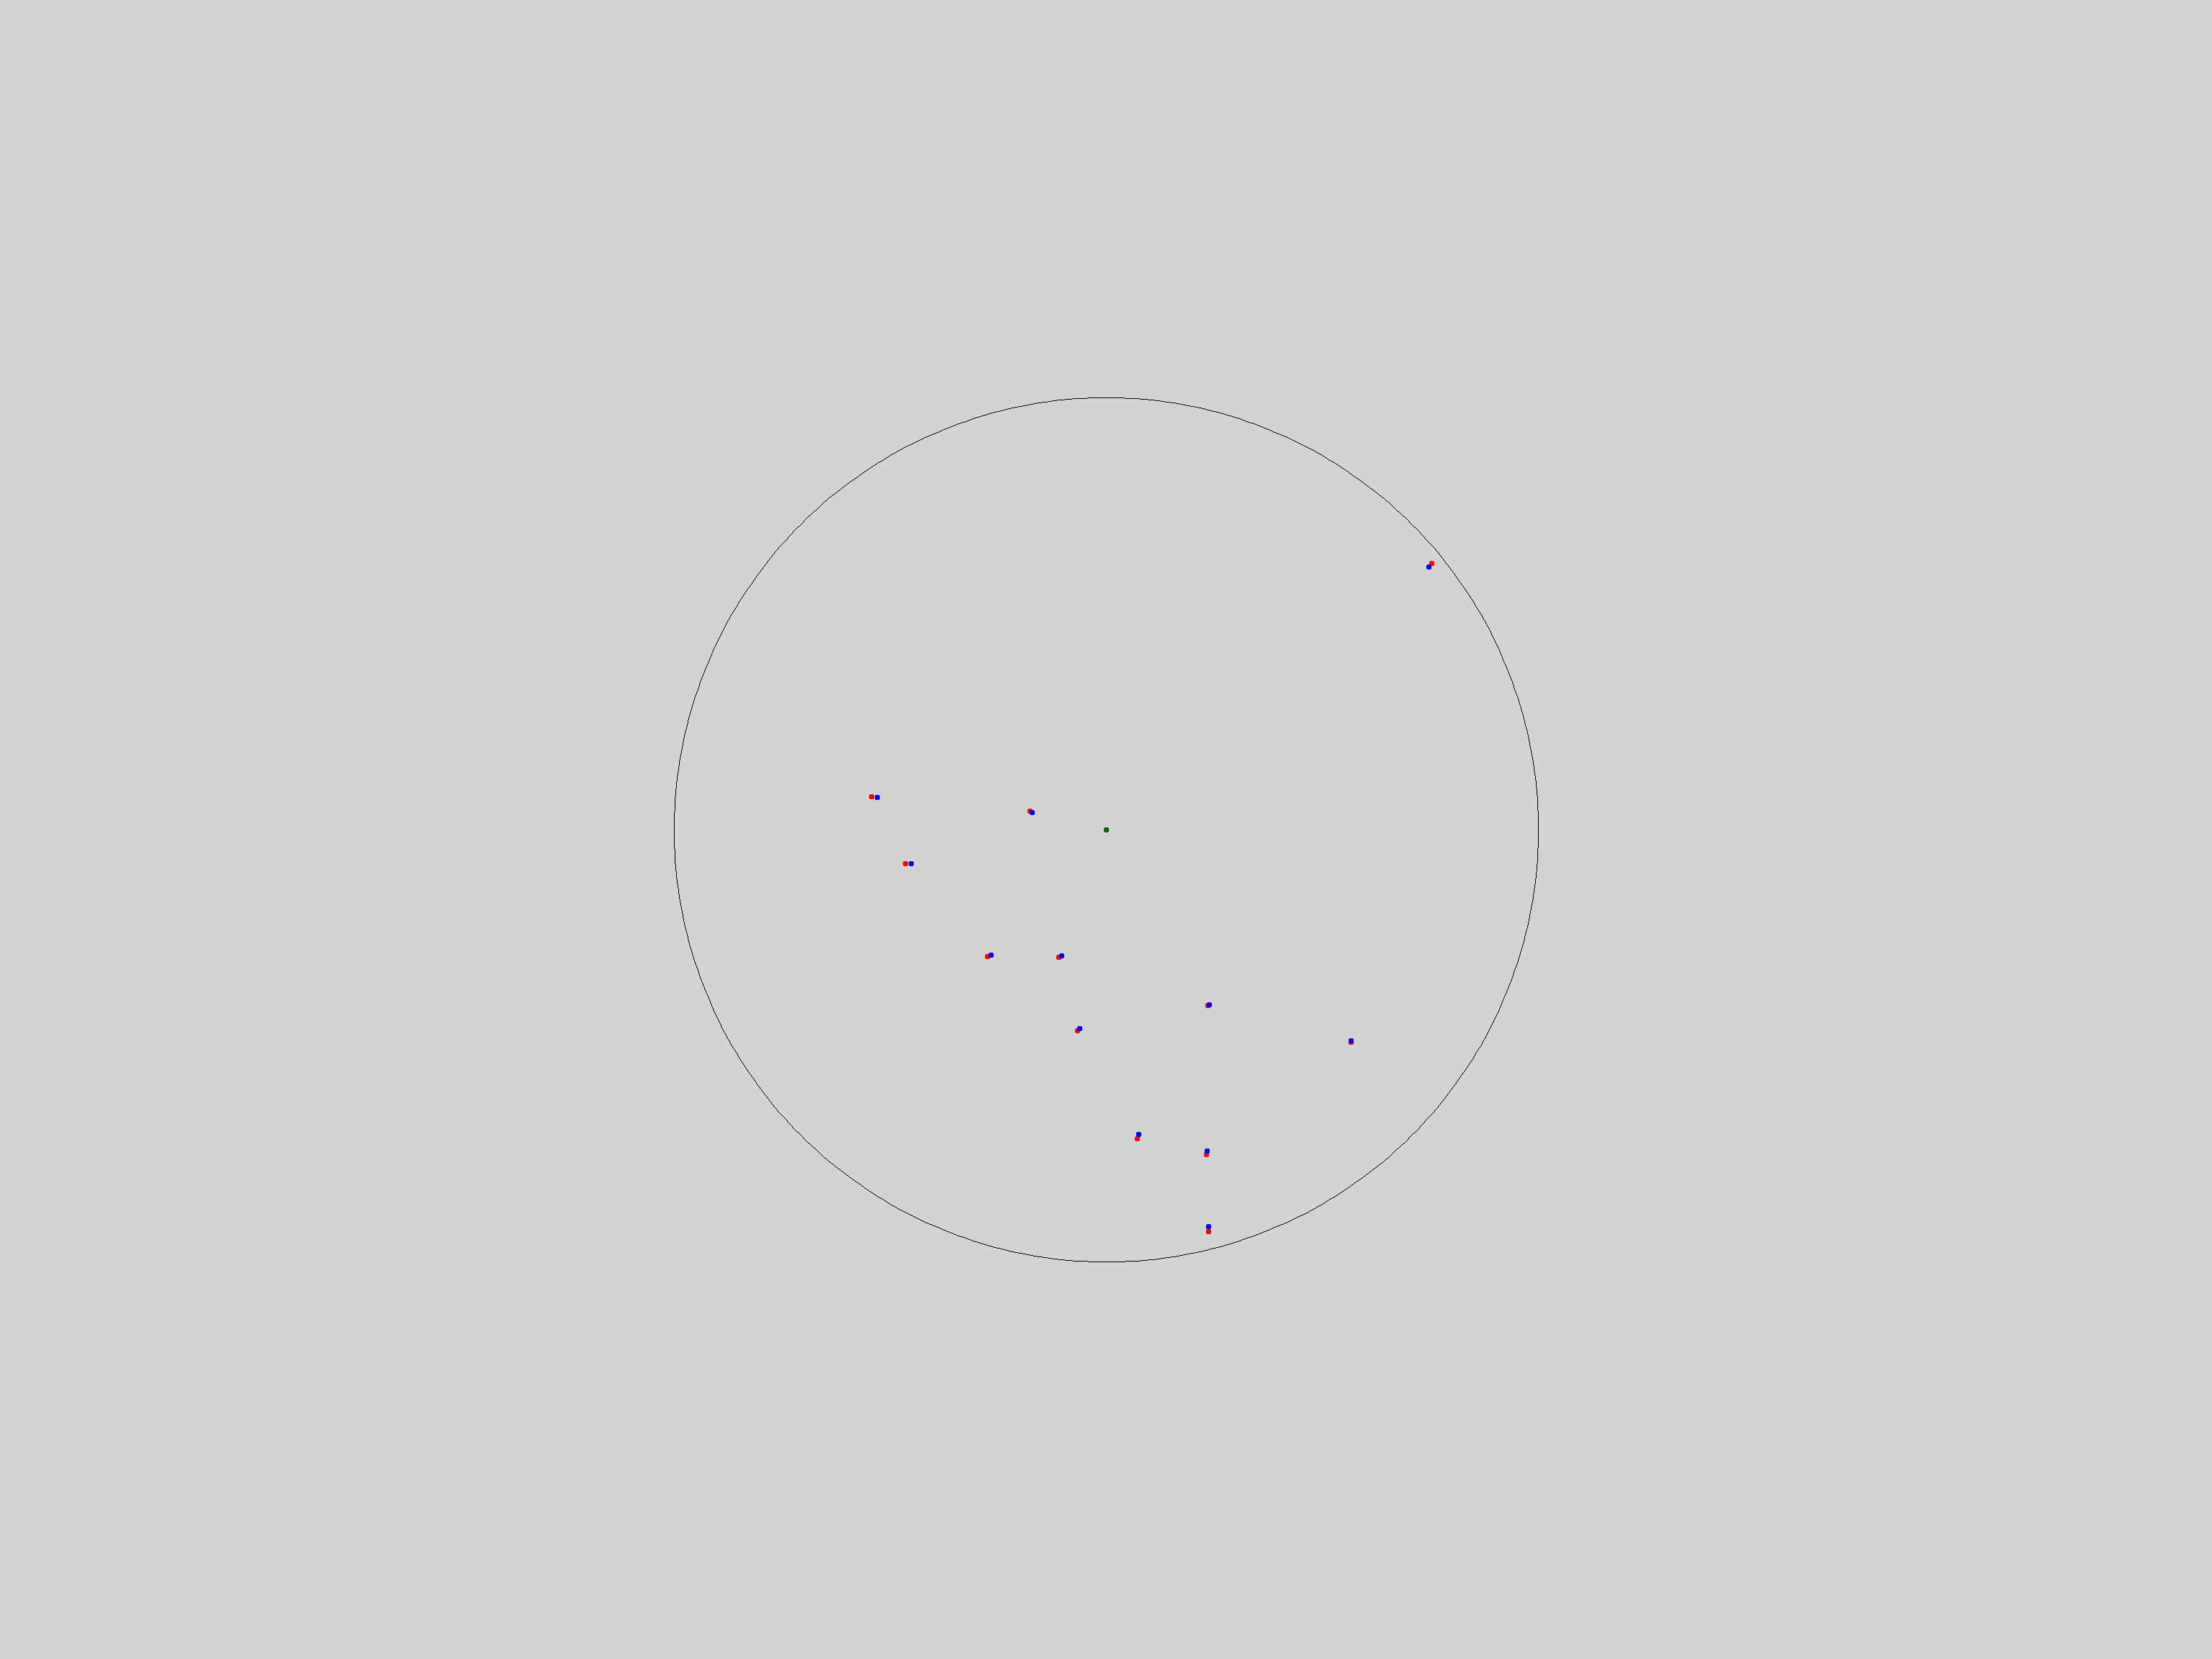

In [58]:
scatter35 = Image.new('RGB', (w, h), 'lightgray')


draw = ImageDraw.Draw(scatter35)
draw.ellipse((x_c-ELL_RAD, y_c-ELL_RAD, x_c+ELL_RAD, y_c+ELL_RAD), fill='darkgreen')
# Draw central part boundary
draw.ellipse((x_c-CENTER_RAD, y_c-CENTER_RAD, x_c+CENTER_RAD, y_c+CENTER_RAD), outline='black')

for i in xrange(N): # draw star points
    draw.ellipse((nlX35[i]-ELL_RAD, nlY35[i]-ELL_RAD, nlX35[i]+ELL_RAD, nlY35[i]+ELL_RAD), fill='red')
    draw.ellipse((nrX35[i]-ELL_RAD, nrY35[i]-ELL_RAD, nrX35[i]+ELL_RAD, nrY35[i]+ELL_RAD), fill='blue')
scatter35

Выходные данные программы:

1) $\Delta x_i, \Delta y_i, \; i = 1,N$

2) $\sigma^2 = \frac{1}{N} \sum\limits_{i=1}^{N} 
                \left( \Delta x_i^2 + \Delta y_i^2 \right)$
                
3) $ 
     M_x = \max\limits_{i=1,N} \{\Delta x_i\}, \;
     M_y = \max\limits_{i=1,N} \{\Delta y_i\}, \;
     M = \max\{M_x, M_y\}
   $                

In [59]:
"""
For all stars -- calculate distance (by x, by y) 
between corresponding stars on aligned images:
\Delta_x, \Delta_y;
\sigma^2;
M_x, M_y, M
""";

In [60]:
"""
a) Affine
""";

In [61]:
delX = np.zeros_like(nlX)
delY = np.zeros_like(nlY)

In [62]:
delX = abs(nlX - rX)
delY = abs(nlY - rY)
print "delX:", delX
print "delY:", delY

delX: [ 0.2266  0.2794  0.3716  0.2545  0.4746  0.5106  1.1886  0.0794  0.7952
  1.5901  0.2365  1.1937]
delY: [ 0.7985  0.8922  1.1202  1.1471  0.3271  0.779   0.9865  0.897   0.7769
  1.0731  0.846   0.1291]


In [63]:
sigSqr = 1.0 / N * sum(delX**2 + delY**2)
mX = max(delX)
mY = max(delY)
m = max(mX, mY)

print "mX: %.4f mY: %.4f m: %.4f" % (mX, mY, m)
print "sigSqr: %.4f" % sigSqr

mX: 1.5901 mY: 1.1471 m: 1.5901
sigSqr: 1.3219


In [64]:
"""
b) Affine + Ditortion3
""";

In [65]:
delX3 = np.zeros_like(nlX3)
delY3 = np.zeros_like(nlY3)

In [66]:
delX3 = abs(nlX3 - nrX3)
delY3 = abs(nlY3 - nrY3)
print "delX3:", delX3
print "delY3:", delY3

delX3: [ 0.4785  1.3468  0.4935  0.6177  0.6405  3.5151  0.7852  2.0303  0.6484
  0.9794  1.5546  3.7578]
delY3: [ 1.0185  1.0361  0.7144  2.5844  3.565   0.9037  1.0164  1.0956  1.2165
  0.0457  1.3329  0.0817]


In [67]:
sigSqr3 = 1.0 / N * sum(delX3**2 + delY3**2)
mX3 = max(delX3)
mY3 = max(delY3)
m3 = max(mX3, mY3)
print "mX3: %.4f mY3: %.4f m3: %.4f" % (mX3, mY3, m3)

print "sigSqr3: %.4f" % sigSqr3

mX3: 3.7578 mY3: 3.5650 m3: 3.7578
sigSqr3: 5.5346


In [68]:
"""
b) Affine + Ditortion3,5
""";

In [69]:
delX35 = np.zeros_like(nlX35)
delY35 = np.zeros_like(nlY35)

In [70]:
delX35 = abs(nlX35 - nrX35)
delY35 = abs(nlY35 - nrY35)
print "delX35:", delX35
print "delY35:", delY35

delX35: [ 1.3092  3.5382  1.4396  2.3156  0.5731  7.6629  2.8583  4.8682  2.8803
  0.2095  3.2619  7.3675]
delY35: [ 4.662   1.6188  0.4011  6.1258  7.0479  1.2263  1.4003  1.9931  2.8233
  1.9242  5.0403  0.2264]


In [71]:
sigSqr35 = 1.0 / N * sum(delX35**2 + delY35**2)
mX35 = max(delX35)
mY35 = max(delY35)
m35 = max(mX35, mY35)

print "mX35: %.4f mY35: %.4f m35: %.4f" % (mX35, mY35, m35)
print "sigSqr35: %.4f" % sigSqr35

mX35: 7.6629 mY35: 7.0479 m35: 7.6629
sigSqr35: 28.5106


In [72]:
"""
Save results: mode=("a" / "d3" / "d35")
radius, N, sigma^2, M
""";

In [73]:
res_fname = results_folder + os.sep +"results_a.txt"
res_fname3 = results_folder + os.sep + "results_d3.txt"
res_fname35 = results_folder + os.sep + "results_d35.txt"

In [74]:
print res_fname
print res_fname3
print res_fname35

results/2016nov-11/exp-Feb-2017/results_a.txt
results/2016nov-11/exp-Feb-2017/results_d3.txt
results/2016nov-11/exp-Feb-2017/results_d35.txt


In [75]:
header = "# CENTER_RAD, N, sigSqr, m"
line = " ".join(str(e) for e in [CENTER_RAD, N, sigSqr, m])
print(line)

600 12 1.32185137144 1.59011188262


In [76]:
line3 = " ".join(str(e) for e in [CENTER_RAD, N, sigSqr3, m3])
print(line3)

600 12 5.53457983255 3.75778445191


In [77]:
line35 = " ".join(str(e) for e in [CENTER_RAD, N, sigSqr35, m35])
print(line35)

600 12 28.5106213452 7.66287345164


In [78]:
def write_to_file(res_fname, line):
    # if file exists -- append
    if os.path.isfile(res_fname):
        with open(res_fname, 'a') as fout:
            fout.write(line)
            fout.write('\n')

    # If file doest exist -- create new
    else:
        with open(res_fname, 'w') as fout:
            fout.write(header)
            fout.write('\n')
            fout.write(line)
            fout.write('\n')

In [79]:
write_to_file(res_fname, line)
write_to_file(res_fname3, line3)
write_to_file(res_fname35, line35)

"4." Построить графики зависимости $\sigma$ и $M$ от размера круга для аффинного, аффин+дист.3 порядка и аффин+дист.3 порядка+дист 5
порядка.

In [80]:
"""
Plot graph sigma^2(radius), M(radius)
""";

In [81]:
# Load data from files "results_a.txt, results_d3.txt, results_d35.txt"
# (without header -- 1st string)
# load to arrays resA, resD3, resD35


In [82]:
# Make data unique in resA, resD3, resD35 
# (remove duplicating rows)

In [83]:
# Make arrays of radius, Num stars, sigma Squared, M

In [84]:
# Plot sigma^2(radius), M(radius) with 3 curves on each (A, D3, D35)